--- WiDiD: Incremental Word Sense Discovery for Parliamentary Speeches ---
Term 27, Year 1–2

In [3]:
# ## Imports
%pip install "elasticsearch==8.6.2" sentence-transformers scikit-learn pandas matplotlib
from elasticsearch import Elasticsearch
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AffinityPropagation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, os

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [4]:
# ## Configuration
INDEX_NAME = "parliament_speeches"
ES_URL = "https://analog-advisory-many-specialists.trycloudflare.com"   # adjust if different
TARGET_WORDS = ["vergi"]
START_TERM = 17
END_TERM = 27
YEARS_PER_TERM = 5
BASELINE_MAX_CLUSTERS = 50
MAX_CLUSTERS = 100
SIMILARITY_THRESHOLD = 0.8
TOP_K_CLUSTERS = 3  # Track top-3 clusters per year
OUTPUT_DIR = "./lorenz_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [5]:
# ## Connect to Elasticsearch
es = Elasticsearch(ES_URL)
print("Connected to Elasticsearch ")
print(es.info().body["version"]["number"])

Connected to Elasticsearch 
8.6.1


## Helper Functions

In [6]:
def fetch_speeches(term, year, size=10000):
    """Fetch speeches for a specific term and year."""
    query = {
        "size": size,
        "_source": ["content", "term", "year"],
        "query": {
            "bool": {
                "must": [
                    {"term": {"term": term}},
                    {"term": {"year": year}}
                ]
            }
        }
    }
    res = es.search(index=INDEX_NAME, body=query)
    return [hit["_source"]["content"] for hit in res["hits"]["hits"]]

In [7]:
def make_term_year_tuples(start_term, end_term):
    result = []
    for term in range(start_term, end_term + 1):
        for year in range(1, 6):
            result.append((term, year))
    return result

TERM_YEAR_TUPLES=make_term_year_tuples(START_TERM,END_TERM)
print(f"Processing {len(TERM_YEAR_TUPLES)} term-year pairs from {TERM_YEAR_TUPLES[0]} to {TERM_YEAR_TUPLES[-1]}")

Processing 55 term-year pairs from (17, 1) to (27, 5)


In [8]:
def extract_contexts(texts, target_word, window=10):
    """Extract short context windows around target word and its morphological variations."""
    contexts = []
    # Create regex pattern to match target word and any Turkish suffixes
    pattern = re.compile(rf"\b{re.escape(target_word.lower())}\w*\b")

    for t in texts:
        tokens = re.findall(r"\w+", t.lower()) # simple tokenization, one or more word characters
        for i, tok in enumerate(tokens):
            # Use regex to match the word and its variations
            if pattern.match(tok):
                start = max(0, i - window)
                end = min(len(tokens), i + window + 1)
                snippet = " ".join(tokens[start:end])
                contexts.append(snippet)
    return contexts

In [9]:
def compute_embeddings(model, contexts):
    """Compute embeddings for context snippets."""
    if len(contexts) == 0:
        return np.empty((0, model.get_sentence_embedding_dimension()))
    return model.encode(contexts, show_progress_bar=True)

In [10]:
def get_cluster_prototypes(X, labels, return_label_ids=False):
    """Compute centroids for each cluster and optionally return their IDs."""
    clusters = []
    label_ids = []
    for label in np.unique(labels):
        if label == -1:
            continue
        members = X[labels == label]
        if len(members) == 0:
            continue
        centroid = np.mean(members, axis=0)
        clusters.append(centroid)
        label_ids.append(label)
    clusters = np.array(clusters)
    if return_label_ids:
        return clusters, label_ids
    return clusters

In [11]:
def show_top_contexts(contexts, labels, n=3):
    """Print representative contexts for each cluster."""
    df = pd.DataFrame({"cluster": labels, "context": contexts})
    grouped = df.groupby("cluster")["context"].apply(list)
    for cluster, examples in grouped.items():
        cluster_name = "overflow/filtered" if cluster == -1 else cluster
        print(f"\n🌀 Cluster {cluster_name} ({len(examples)} examples):")
        for ex in examples[:n]:
            print("   •", ex[:200].replace("\n", " ") + ("..." if len(ex) > 200 else ""))

In [12]:
def limit_clusters(labels, max_clusters):
    """Keep only the largest max_clusters and map the rest to -1."""
    if max_clusters is None:
        return labels, np.unique(labels).tolist()
    labels = np.asarray(labels)
    unique, counts = np.unique(labels, return_counts=True)
    cluster_counts = [
        (label, count) for label, count in zip(unique, counts) if label != -1
    ]
    cluster_counts.sort(key=lambda item: item[1], reverse=True)
    keep = [label for label, _ in cluster_counts[:max_clusters]]
    if not keep:
        return np.full_like(labels, -1), []
    filtered = np.array([label if label in keep else -1 for label in labels], dtype=labels.dtype)
    return filtered, keep


class ClusterAligner:
    """Keeps global cluster IDs and assigns consistent colors over time."""

    def __init__(self, max_clusters=100, similarity_threshold=0.8, cmap_name="gist_ncar"):
        self.max_clusters = max_clusters
        self.similarity_threshold = similarity_threshold
        self.centroids = []
        self.global_ids = []
        self.cmap = plt.cm.get_cmap(cmap_name, max_clusters)
        self.palette = [self.cmap(i) for i in range(self.cmap.N)]
        self.overflow_color = (0.65, 0.65, 0.65, 1.0)

    def _add_centroid(self, centroid):
        if len(self.global_ids) >= self.max_clusters:
            return -1
        new_id = len(self.global_ids)
        self.centroids.append(centroid)
        self.global_ids.append(new_id)
        return new_id

    def _match_or_create(self, centroid):
        centroid = centroid.reshape(1, -1)
        if not self.centroids:
            return self._add_centroid(centroid)
        stacked = np.vstack(self.centroids)
        sims = cosine_similarity(stacked, centroid)[:, 0]
        best_idx = int(np.argmax(sims))
        if sims[best_idx] >= self.similarity_threshold:
            return self.global_ids[best_idx]
        return self._add_centroid(centroid)

    def align(self, raw_labels, centroid_map):
        aligned = np.full_like(raw_labels, -1)
        for local_label, centroid in centroid_map.items():
            global_id = self._match_or_create(centroid)
            if global_id == -1:
                continue
            aligned[raw_labels == local_label] = global_id
        return aligned

    def colors_for(self, labels):
        return [
            self.palette[label]
            if 0 <= label < len(self.palette)
            else self.overflow_color
            for label in labels
        ]

    def get_color(self, label):
        """Get color for a single label."""
        if 0 <= label < len(self.palette):
            return self.palette[label]
        return self.overflow_color


def plot_tsne(term, year, word, embeddings, aligned_labels, aligner):
    if len(embeddings) < 2:
        print("  Skipping t-SNE (insufficient embeddings).")
        return
    desired = max(5, len(embeddings) // 3)
    max_valid = max(1, len(embeddings) - 1)
    perplexity = min(desired, max_valid, 30)
    tsne_coords = TSNE(n_components=2, random_state=42, perplexity=perplexity).fit_transform(embeddings)

    plt.figure(figsize=(12, 10))

    # Plot by cluster using numeric markers (memory efficient)
    unique_labels = sorted(set(label for label in aligned_labels if label >= 0))

    for cluster_id in unique_labels:
        mask = aligned_labels == cluster_id
        cluster_coords = tsne_coords[mask]
        color = aligner.get_color(cluster_id)

        # Use cluster number as marker in scatter plot
        plt.scatter(cluster_coords[:, 0], cluster_coords[:, 1],
                   c=[color], marker=f'${cluster_id}$', s=200,
                   alpha=0.8, edgecolors='black', linewidths=0.5)

    # Plot filtered points if any
    if -1 in aligned_labels:
        mask = aligned_labels == -1
        overflow_coords = tsne_coords[mask]
        plt.scatter(overflow_coords[:, 0], overflow_coords[:, 1],
                   c=[aligner.overflow_color], marker='x', s=30,
                   alpha=0.3, linewidths=0.5)

    plt.title(f"'{word}' Term {term} Year {year} (t-SNE)", fontsize=14, fontweight='bold')
    plt.xlabel("Dim 1", fontsize=12)
    plt.ylabel("Dim 2", fontsize=12)
    plt.grid(alpha=0.3, linestyle='--')
    plt.tight_layout()
    tsne_path = os.path.join(OUTPUT_DIR, f"tsne_term{term}_year{year}_{word}.png")
    plt.savefig(tsne_path, dpi=150, bbox_inches="tight")
    plt.show()
    print(f"  Saved t-SNE plot to {tsne_path}")


In [13]:
def create_cluster_guide(cluster_contexts_map, target_word, output_dir, aligner):
    """
    Create a cluster guide with summary CSV and detailed context file.
    Shows what each global cluster represents semantically.
    """

    if not cluster_contexts_map:
        print("  No clusters to document.")
        return

    # Calculate statistics for each cluster
    guide_rows = []
    for global_id in sorted(cluster_contexts_map.keys()):
        contexts = cluster_contexts_map[global_id]
        term_years = sorted(set(f"T{ctx['term']}Y{ctx['year']}" for ctx in contexts))

        guide_rows.append({
            'global_id': global_id,
            'color_index': global_id,
            'total_contexts': len(contexts),
            'term_year_span': ', '.join(term_years),
            'num_appearances': len(term_years)
        })

    # Create summary CSV
    df_summary = pd.DataFrame(guide_rows).sort_values('total_contexts', ascending=False)
    summary_path = os.path.join(output_dir, f"cluster_guide_{target_word}_summary.csv")
    df_summary.to_csv(summary_path, index=False)
    print(f"  Saved cluster summary to {summary_path}")

    # Create detailed context file
    context_file_path = os.path.join(output_dir, f"cluster_guide_{target_word}_contexts.txt")
    with open(context_file_path, 'w', encoding='utf-8') as f:
        f.write(f"{'='*80}\n")
        f.write(f"CLUSTER GUIDE FOR '{target_word.upper()}'\n")
        f.write(f"Generated: {pd.Timestamp.now()}\n")
        f.write(f"Total clusters: {len(cluster_contexts_map)}\n")
        f.write(f"{'='*80}\n\n")

        # Sort clusters by total contexts (most common first)
        for global_id in sorted(cluster_contexts_map.keys(),
                               key=lambda x: len(cluster_contexts_map[x]),
                               reverse=True):
            contexts = cluster_contexts_map[global_id]
            term_years = sorted(set(f"T{ctx['term']}Y{ctx['year']}" for ctx in contexts))

            # Get color info
            color = aligner.get_color(global_id)
            color_hex = '#{:02x}{:02x}{:02x}'.format(
                int(color[0]*255), int(color[1]*255), int(color[2]*255)
            )

            f.write(f"\n{'='*80}\n")
            f.write(f"CLUSTER {global_id} (Color: {color_hex})\n")
            f.write(f"{'-'*80}\n")
            f.write(f"Total contexts: {len(contexts)}\n")
            f.write(f"Appearances: {len(term_years)} term-years\n")
            f.write(f"Term-year span: {', '.join(term_years)}\n")
            f.write(f"\nREPRESENTATIVE CONTEXTS:\n")
            f.write(f"{'-'*80}\n")

            # Show up to 15 diverse examples
            shown = 0
            for ctx_item in contexts[:15]:
                f.write(f"\n[{ctx_item['term']}-{ctx_item['year']}] ")
                f.write(ctx_item['context'][:250])
                if len(ctx_item['context']) > 250:
                    f.write("...")
                f.write("\n")
                shown += 1

            if len(contexts) > 15:
                f.write(f"\n... and {len(contexts) - 15} more contexts\n")

    print(f"  Saved detailed contexts to {context_file_path}")
    print(f"  Total clusters documented: {len(cluster_contexts_map)}")

    return df_summary


In [14]:
# ## Load Sentence Transformer Model
model = SentenceTransformer("all-MiniLM-L6-v2")
print("Model loaded ")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Model loaded 


In [15]:
# Create Color Reference and Mapping
def create_color_reference(cluster_contexts_map, target_word, output_dir, aligner):
    """Create color reference chart and mapping CSV."""

    if not cluster_contexts_map:
        print("  No clusters to map.")
        return

    # Get all global IDs
    used_cluster_ids = sorted(cluster_contexts_map.keys())

    # Create color mapping CSV
    color_mapping = []
    for global_id in used_cluster_ids:
        color = aligner.get_color(global_id)
        color_hex = '#{:02x}{:02x}{:02x}'.format(
            int(color[0]*255), int(color[1]*255), int(color[2]*255)
        )
        color_rgb = f"({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)})"

        color_mapping.append({
            'global_id': global_id,
            'hex_color': color_hex,
            'rgb_color': color_rgb
        })

    df_colors = pd.DataFrame(color_mapping)
    color_csv_path = os.path.join(output_dir, f'cluster_colors_{target_word}.csv')
    df_colors.to_csv(color_csv_path, index=False)
    print(f"  Saved color mapping to {color_csv_path}")

    # Print console reference
    print("\n=== Color Reference ===")
    for _, row in df_colors.iterrows():
        print(f"Cluster {row['global_id']}: {row['hex_color']}")

    # Create visual color reference chart
    import matplotlib.patches as mpatches

    fig, ax = plt.subplots(figsize=(12, max(6, len(used_cluster_ids) // 4)))
    patches = []

    for global_id in used_cluster_ids:
        color = aligner.get_color(global_id)
        patches.append(mpatches.Patch(color=color, label=f'Cluster {global_id}'))

    ax.legend(handles=patches, loc='center', ncol=min(4, len(patches)), fontsize=10)
    ax.axis('off')
    plt.title(f"Color Reference for '{target_word}' Clusters", fontsize=14, fontweight='bold')
    plt.tight_layout()

    chart_path = os.path.join(output_dir, f'color_reference_{target_word}.png')
    plt.savefig(chart_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"  Saved color reference chart to {chart_path}")

    return df_colors


## 6️⃣ Main Loop Over Words



===  Analyzing 'vergi' across 55 term-year pairs ===

--- Term 17, Year 1 ---


/tmp/ipython-input-167963020.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  self.cmap = plt.cm.get_cmap(cmap_name, max_clusters)
/tmp/ipython-input-291667405.py:15: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  res = es.search(index=INDEX_NAME, body=query)


  Contexts: 14


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Raw clusters: 5, kept: 5 (cap=50)
  Global clusters represented: 4

=== Representative Contexts ===

🌀 Cluster 0 (9 examples):
   • üretici 57 milyar lira civarında alacağını mart ayı içerisinde alıp vergisini yatırabilecek midir sayın milletvekilleri konuya objektif ve realiteleri göz önünde
   • ve köyişleri bakanımız teşrif ettiler kendilerine sunacağım tapulv olmasına resmen vergilendirilmesine rağmen bazı alanlar orman içi sahalar olarak mütalaa edilmekte ve
   • ve köyişleri bakanımız teşrif ettiler kendilerine sunacağım tapulv olmasına resmen vergilendirilmesine rağmen bazı alanlar orman içi sahalar olarak mütalaa edilmekte ve

🌀 Cluster 1 (2 examples):
   • değeri ise maa page 4 lesef düşüş kaydetmektedir bu husus vergi iadesi ve ucuz faizle dışsatım politikasının mahsullerinden başka bir şey
   • değeri ise maa page 4 lesef düşüş kaydetmektedir bu husus vergi iadesi ve ucuz faizle dışsatım politikasının mahsullerinden başka bir şey

🌀 Cluster 2 (1 examples):
   • zerzevat al

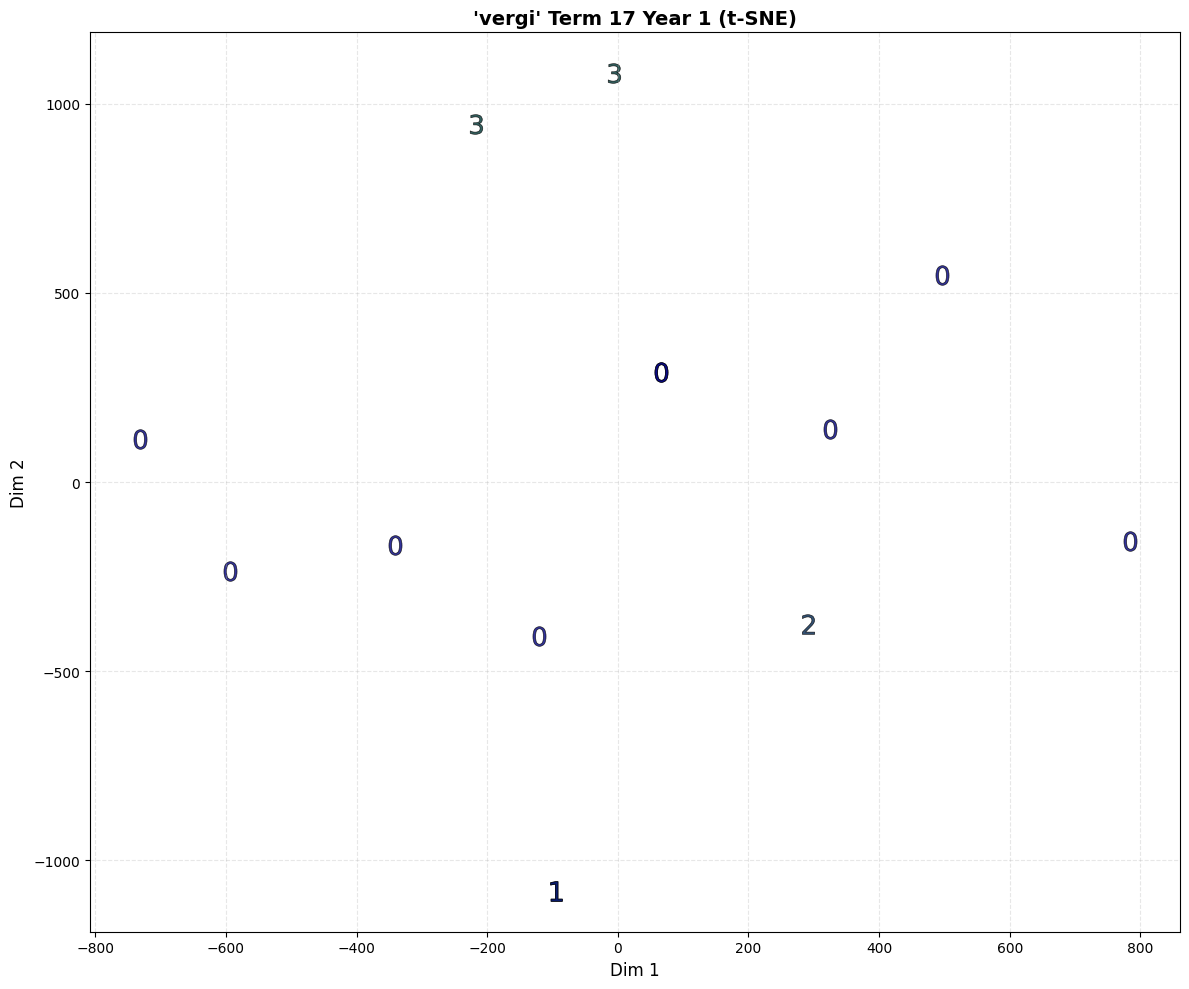

  Saved t-SNE plot to ./lorenz_results/tsne_term17_year1_vergi.png

--- Term 17, Year 2 ---
  Contexts: 0
  Not enough contexts, skipping this slice.

--- Term 17, Year 3 ---


/tmp/ipython-input-291667405.py:15: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  res = es.search(index=INDEX_NAME, body=query)


  Contexts: 0
  Not enough contexts, skipping this slice.

--- Term 17, Year 4 ---
  Contexts: 0
  Not enough contexts, skipping this slice.

--- Term 17, Year 5 ---
  Contexts: 0
  Not enough contexts, skipping this slice.

--- Term 18, Year 1 ---
  Contexts: 51


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

  Raw clusters: 13, kept: 13 (cap=100)
  Global clusters represented: 10

=== Representative Contexts ===

🌀 Cluster 4 (4 examples):
   • sağlık hizmetleri vergisinin i hdası ile 3074 sayılı akaryakıtı tüketim vergisi kanunu 197 sayılı motorlu taşıtlar vergisi kanunu 1318 sayılı finansman
   • 3074 sayılı akaryakıtı tüketim vergisi kanunu 197 sayılı motorlu taşıtlar vergisi kanunu 1318 sayılı finansman kanunu 193 sayılı gelir vergisi kanunu
   • taşıtlar vergisi kanunu 1318 sayılı finansman kanunu 193 sayılı gelir vergisi kanunu 213 sayılı vergi usul kanunu 6183 sayılı amme alacaklarının

🌀 Cluster 5 (25 examples):
   • anladılık karabulut gibi çöken zamlarla dış borçları ödemek istiyorsunuz zamlarla vergi alıyorsunuz ama lütfen türkiye deki manzaraya bakınız bir yanda devlet
   • zam yapmadan da devleti yönetebilir akılcı ve adil bir vasıtasız vergi politikası izleyerek kazananların vergilendirilmesi mümkün değil mi sosyal sigortalar kurumu
   • yönetebilir akılcı ve adil bir vasıtası

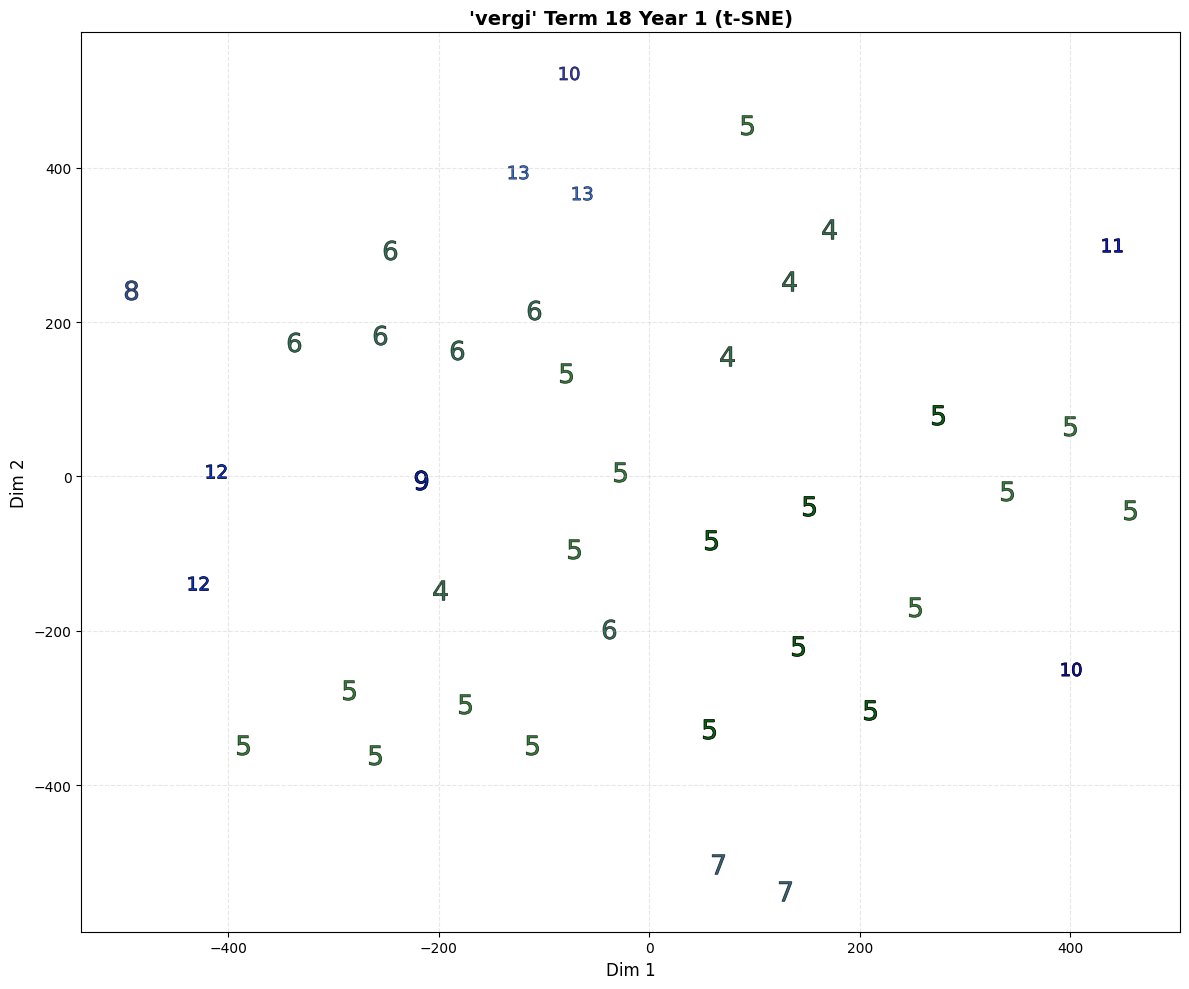

  Saved t-SNE plot to ./lorenz_results/tsne_term18_year1_vergi.png

--- Term 18, Year 2 ---
  Contexts: 0
  Not enough contexts, skipping this slice.

--- Term 18, Year 3 ---


/tmp/ipython-input-291667405.py:15: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  res = es.search(index=INDEX_NAME, body=query)


  Contexts: 0
  Not enough contexts, skipping this slice.

--- Term 18, Year 4 ---
  Contexts: 0
  Not enough contexts, skipping this slice.

--- Term 18, Year 5 ---
  Contexts: 0
  Not enough contexts, skipping this slice.

--- Term 19, Year 1 ---
  Contexts: 40


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

  Raw clusters: 11, kept: 11 (cap=100)
  Global clusters represented: 11

=== Representative Contexts ===

🌀 Cluster 5 (3 examples):
   • bin dördüncü bölgede 640 bin lira ödemek zorundadır götürü usulde vergi ödeyen bir seyyar satıcı en az 1 milyon 250 bin
   • kazansa da kazanmasa da 3 milyon 530 bin türk lirası vergi ödemek mecburiyetindedir sayın milletvekilleri vergi kutsaldır devletin ayakta durabilmesi için
   • milyon 530 bin türk lirası vergi ödemek mecburiyetindedir sayın milletvekilleri vergi kutsaldır devletin ayakta durabilmesi için kazanan herkesin vergi ödemesi şarttır

🌀 Cluster 6 (12 examples):
   • defi f pul ordino ardiye ulaştırma fonu ve katma değer vergisi ile birlikte artış yüzde 97 ye ulaşmaktadır sayın milletvekilleri bu
   • 4 ankara milletvekili yücel seçkiner ve 10 arkadaşının spor kulüplerinin vergi zam ve cezaları ile sigorta primi cezalarının affına i lişkin
   • rağmen esnaf ve sanatkârlarımızın bir ayda en az beş günü vergi dairesinde geçmektedir muhtas

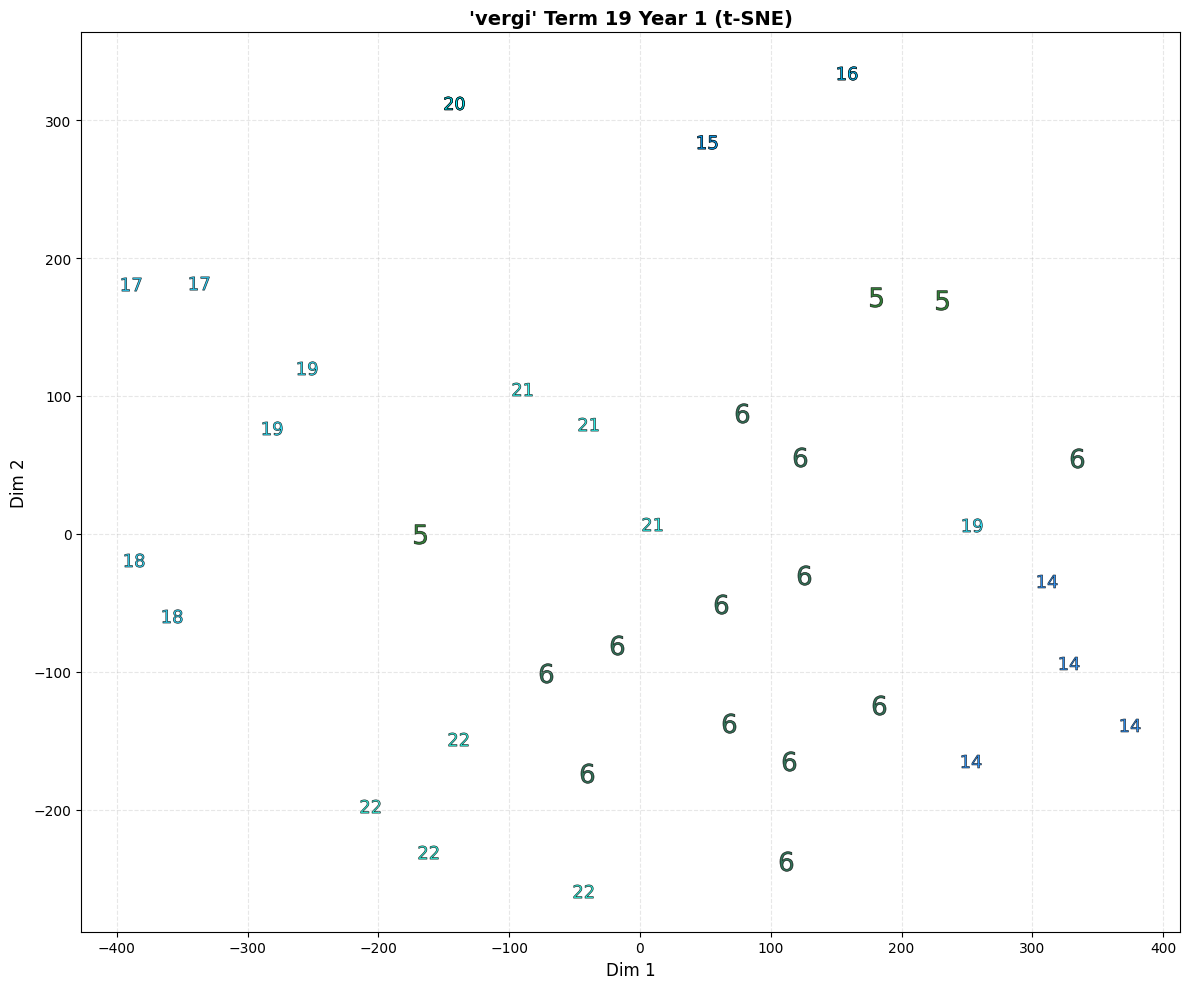

  Saved t-SNE plot to ./lorenz_results/tsne_term19_year1_vergi.png

--- Term 19, Year 2 ---
  Contexts: 0
  Not enough contexts, skipping this slice.

--- Term 19, Year 3 ---


/tmp/ipython-input-291667405.py:15: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  res = es.search(index=INDEX_NAME, body=query)


  Contexts: 0
  Not enough contexts, skipping this slice.

--- Term 19, Year 4 ---
  Contexts: 0
  Not enough contexts, skipping this slice.

--- Term 19, Year 5 ---
  Contexts: 0
  Not enough contexts, skipping this slice.

--- Term 20, Year 1 ---
  Contexts: 0
  Not enough contexts, skipping this slice.

--- Term 20, Year 2 ---
  Contexts: 0
  Not enough contexts, skipping this slice.

--- Term 20, Year 3 ---
  Contexts: 0
  Not enough contexts, skipping this slice.

--- Term 20, Year 4 ---
  Contexts: 0
  Not enough contexts, skipping this slice.

--- Term 20, Year 5 ---
  Contexts: 0
  Not enough contexts, skipping this slice.

--- Term 21, Year 1 ---
  Contexts: 0
  Not enough contexts, skipping this slice.

--- Term 21, Year 2 ---
  Contexts: 0
  Not enough contexts, skipping this slice.

--- Term 21, Year 3 ---
  Contexts: 0
  Not enough contexts, skipping this slice.

--- Term 21, Year 4 ---
  Contexts: 0
  Not enough contexts, skipping this slice.

--- Term 21, Year 5 ---
  Co

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Raw clusters: 3, kept: 3 (cap=100)
  Global clusters represented: 3

=== Representative Contexts ===

🌀 Cluster 6 (6 examples):
   • tanesiproblemlerini dinlemekten inanın üzüntü duyuyorum gerçekten enerji girdi maliyetlerinden tutun vergi yüklerinden tutun osb lerdeki problemlerden tutun da o kapasite kullanım
   • konuşmamda ifade ettiğim gerçeği teyit etti şu şekilde biz sektörel vergi incelemesi yaptırdık dedi yani bir sektör doğru hâlen de o
   • da söyleyemez sayın maliye bakanına da hatırlatmada bulunayım zaman zaman vergi denetimiyle ilgili değerlendirmeler yapıyor bu görev artık gelir i daresi

🌀 Cluster 23 (3 examples):
   • maliyecidir ben de bir maliyeciyim sayın canikli şunu bilir mi vergi usul kanunu nun üçüncü maddesi var ödemeler gayriyasal bile olsa
   • kanunu nun üçüncü maddesi var ödemeler gayriyasal bile olsa o vergi hukuku açısından vergilenir benim ülkemde kazandığım bir parayı nasıl götürür
   • maddesi var ödemeler gayriyasal bile olsa o vergi hukuku açısında

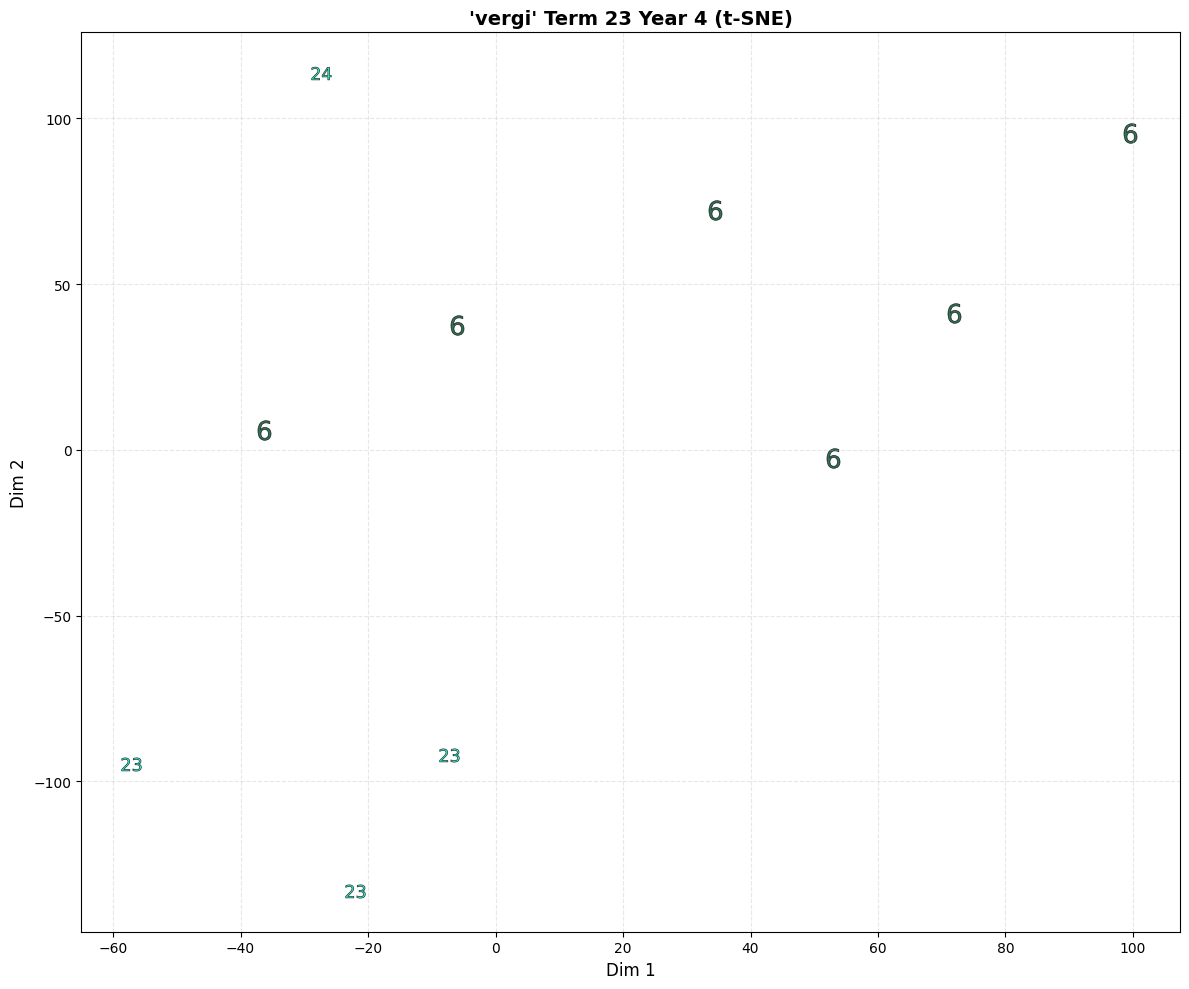

  Saved t-SNE plot to ./lorenz_results/tsne_term23_year4_vergi.png

--- Term 23, Year 5 ---


/tmp/ipython-input-291667405.py:15: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  res = es.search(index=INDEX_NAME, body=query)


  Contexts: 1
  Not enough contexts, skipping this slice.

--- Term 24, Year 1 ---
  Contexts: 0
  Not enough contexts, skipping this slice.

--- Term 24, Year 2 ---
  Contexts: 14


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Raw clusters: 5, kept: 5 (cap=100)
  Global clusters represented: 5

=== Representative Contexts ===

🌀 Cluster 5 (3 examples):
   • teşekkür ediyorum bugün dünya tüketiciler günü bugün türkiye nin dolaylı vergileri dünyanın vergi sisteminin tersine yüzde 75 i bulmaktadır özel tüketim
   • bugün dünya tüketiciler günü bugün türkiye nin dolaylı vergileri dünyanın vergi sisteminin tersine yüzde 75 i bulmaktadır özel tüketim vergisi ve
   • oluşturdular şimdiye kadar hiç kimseye borçlu kalmadılar iyi günlerinde devlete vergilerini verdiler askerliklerini yaptılar bugün de sayın bakan da burada oradaki

🌀 Cluster 6 (4 examples):
   • başkan sayın milletvekilleri kullandığımız elektrik paralarından aldığımız maydanozdan sigaradan kesilen vergilerden finanse edilen trt her zamankinden fazla sansürcü olmuş her zamankinden
   • dünyanın vergi sisteminin tersine yüzde 75 i bulmaktadır özel tüketim vergisi ve katma değer vergisi haksız bir şekilde nihai tüketicinin sırtına
   • yüzde 75 i bulm

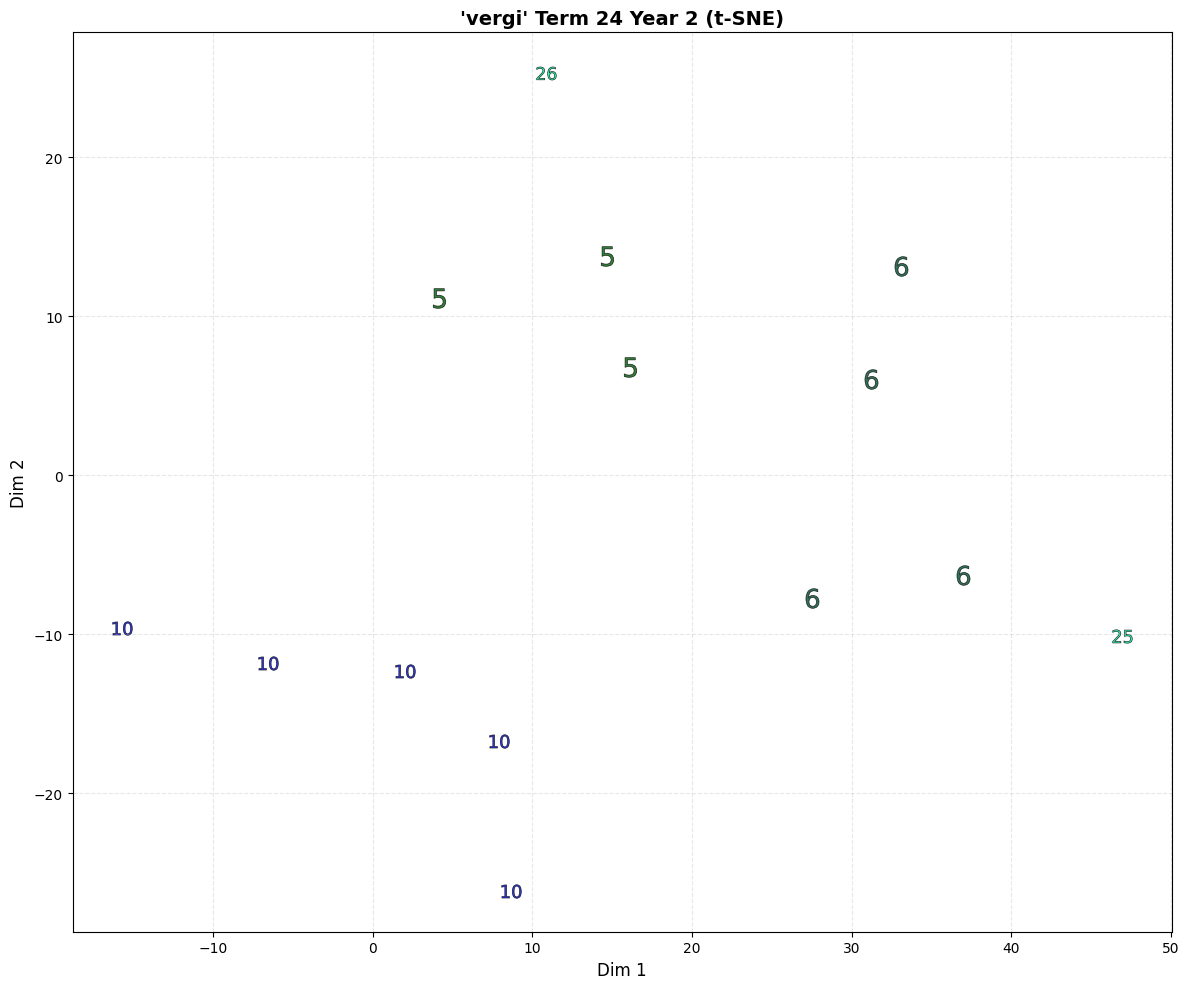

  Saved t-SNE plot to ./lorenz_results/tsne_term24_year2_vergi.png

--- Term 24, Year 3 ---


/tmp/ipython-input-291667405.py:15: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  res = es.search(index=INDEX_NAME, body=query)


  Contexts: 43


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

  Raw clusters: 11, kept: 11 (cap=100)
  Global clusters represented: 10

=== Representative Contexts ===

🌀 Cluster 0 (13 examples):
   • da görevini yerine getiremediği için bu bütçenin kendisine halktan toplanan vergilerle ayrılmasına da gerek yoktur bu şartta kapatılması gerekir saygılar sunuyorum
   • hükûmetinin 11 inci bütçesi de daha önceki bütçeleri gibi tamamen vergiye dayalı kaynaklar üzerine hazırlanmış durumdadır hükûmet bu kaynakları toplumun günlük
   • ciddi sapmaların yaşandığı bir yıl oldu yıl içinde gerçekleştirilen ek vergi tedbirlerine ve bir defaya mahsus gelir kaynaklarına müracaat edilmiş olmasına

🌀 Cluster 5 (10 examples):
   • olmuştur bugün itibarıyla gelir ayağı son derece sağlıktan uzak bir vergi sistemine dayalı gider ayağı ise esnekliğini büyük ölçüde yitirmiş katı
   • çok affedersiniz ama inekler otlamaktadır kocaeli türkiye ye en çok vergi veren bir kent olarak bunu hak etmiyor diye düşünüyorum böyle
   • arsa mafyasından bu yerleri zaten satın almışl

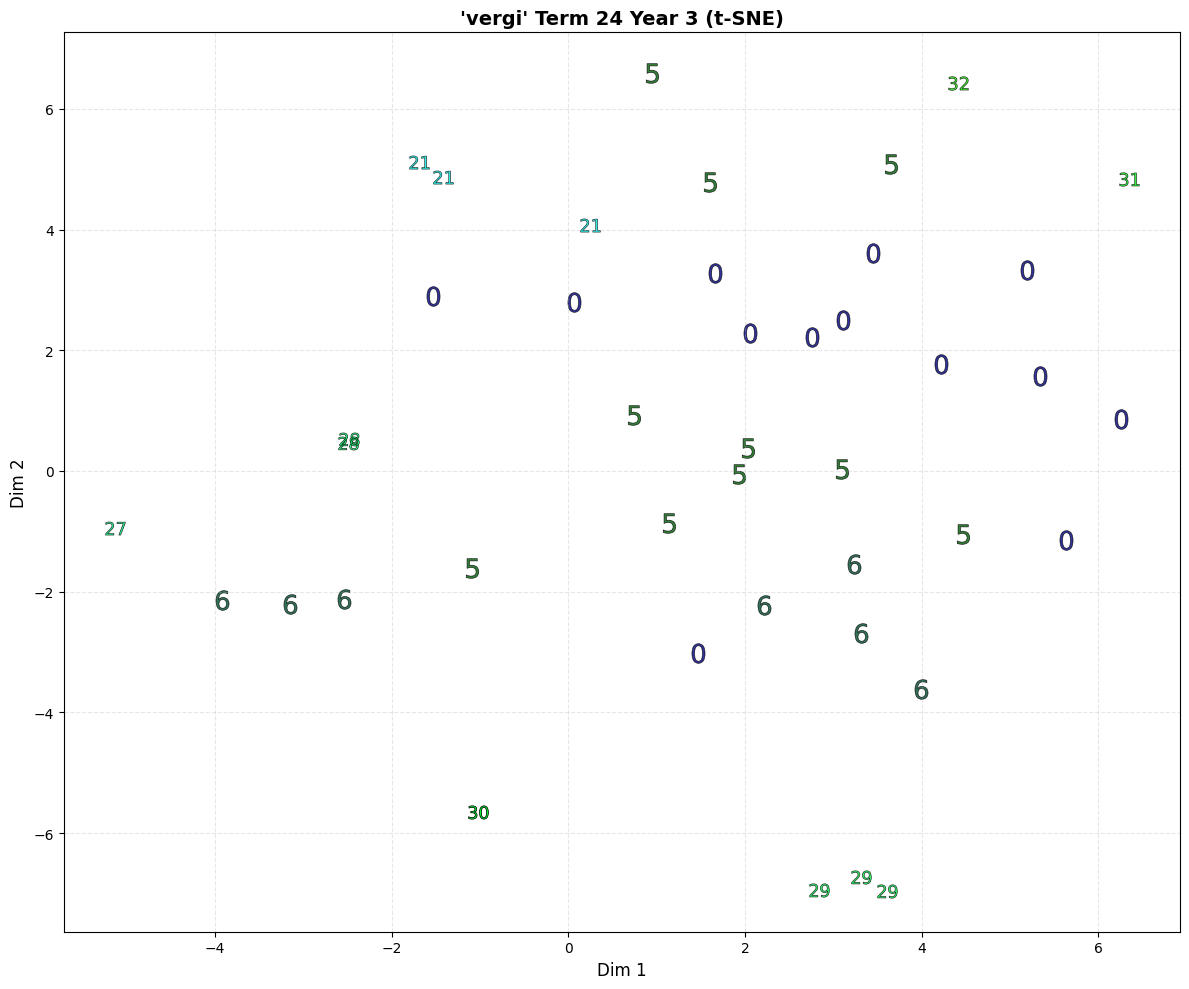

  Saved t-SNE plot to ./lorenz_results/tsne_term24_year3_vergi.png

--- Term 24, Year 4 ---
  Contexts: 0
  Not enough contexts, skipping this slice.

--- Term 24, Year 5 ---


/tmp/ipython-input-291667405.py:15: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  res = es.search(index=INDEX_NAME, body=query)


  Contexts: 0
  Not enough contexts, skipping this slice.

--- Term 25, Year 1 ---
  Contexts: 0
  Not enough contexts, skipping this slice.

--- Term 25, Year 2 ---
  Contexts: 1
  Not enough contexts, skipping this slice.

--- Term 25, Year 3 ---
  Contexts: 0
  Not enough contexts, skipping this slice.

--- Term 25, Year 4 ---
  Contexts: 0
  Not enough contexts, skipping this slice.

--- Term 25, Year 5 ---
  Contexts: 0
  Not enough contexts, skipping this slice.

--- Term 26, Year 1 ---
  Contexts: 3122


Batches:   0%|          | 0/98 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/cluster/_affinity_propagation.py:140: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


  Raw clusters: 390, kept: 100 (cap=100)
  Global clusters represented: 27

=== Representative Contexts ===

🌀 Cluster overflow/filtered (1266 examples):
   • devam ettik 2002 yılında türkiye de devletin topladığı 100 liralık verginin tam 86 lirası faize giderdi altını çiziyorum yıl 2002 100
   • bir gazeteci burada bütçe sırasında çokça konuşulan bir iş adamının vergi cezasının affıyla ilgili vergi borçlarının affıyla ilgili haber yaptığı için
   • sırasında çokça konuşulan bir iş adamının vergi cezasının affıyla ilgili vergi borçlarının affıyla ilgili haber yaptığı için hakkında yakalama kararı çıkartıldı

🌀 Cluster 0 (159 examples):
   • akaryakıt kaçakçılığından sigara kaçakçılığından para kazanıyor insan kaçakçılığından para kazanıyor vergi topluyor öbür kaçakçılardan haraç alıyor bunları önlemek için niye bir
   • açısından sıklıkla başvurulan bir yoldur uzlaşma bu yolla bir taraftan vergi idaresince kanunen alınması gereken vergiler veya cezaların bir bölümünden vazgeçilerek
   

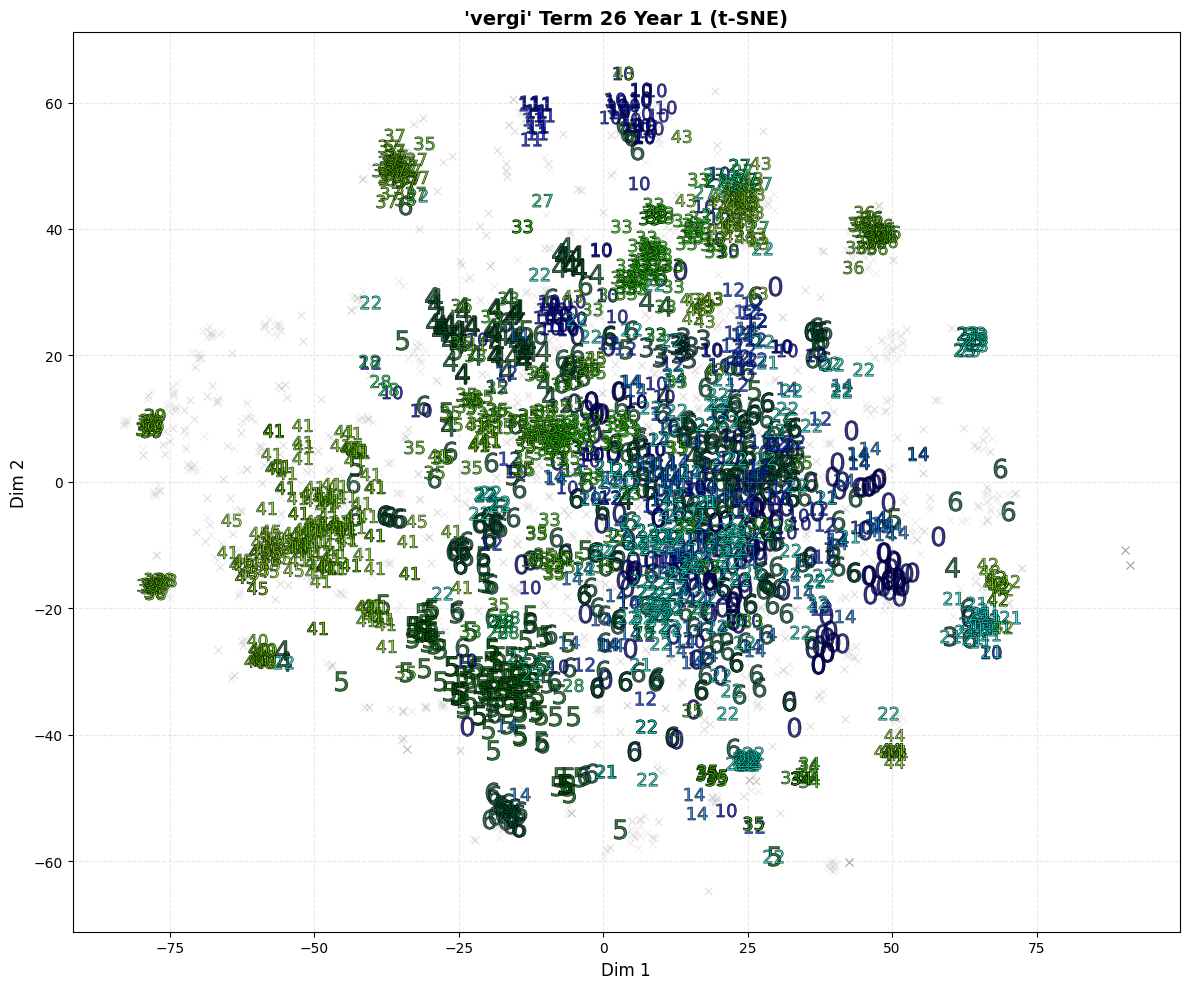

  Saved t-SNE plot to ./lorenz_results/tsne_term26_year1_vergi.png

--- Term 26, Year 2 ---


/tmp/ipython-input-291667405.py:15: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  res = es.search(index=INDEX_NAME, body=query)


ConnectionTimeout: Connection timed out

In [16]:
TARGET_WORDS = ["vergi"]
for target_word in TARGET_WORDS:
    print(f"\n\n===  Analyzing '{target_word}' across {len(TERM_YEAR_TUPLES)} term-year pairs ===")
    aligner = ClusterAligner(max_clusters=MAX_CLUSTERS, similarity_threshold=SIMILARITY_THRESHOLD)
    baseline_used = False
    cluster_contexts_map = {}  # Store contexts per global_id for cluster guide

    for term, year in TERM_YEAR_TUPLES:
        print(f"\n--- Term {term}, Year {year} ---")
        texts = fetch_speeches(term, year)
        contexts = extract_contexts(texts, target_word)
        print(f"  Contexts: {len(contexts)}")
        if len(contexts) < 10:
            print("  Not enough contexts, skipping this slice.")
            continue

        embeddings = compute_embeddings(model, contexts)
        ap = AffinityPropagation(random_state=42)
        ap.fit(embeddings)
        local_labels = ap.labels_

        cap = BASELINE_MAX_CLUSTERS if not baseline_used else MAX_CLUSTERS
        limited_labels, kept_clusters = limit_clusters(local_labels, cap)
        print(f"  Raw clusters: {len(np.unique(local_labels))}, kept: {len(kept_clusters)} (cap={cap})")

        prototypes, proto_labels = get_cluster_prototypes(embeddings, limited_labels, return_label_ids=True)
        centroid_map = dict(zip(proto_labels, prototypes))
        if not centroid_map:
            print("  No clusters survived filtering, skipping visualization.")
            continue

        baseline_used = True
        aligned_labels = aligner.align(limited_labels, centroid_map)
        global_cluster_count = len(set(label for label in aligned_labels if label >= 0))
        print(f"  Global clusters represented: {global_cluster_count}")

        # Store context examples for cluster guide (up to 10 per global cluster per term-year)
        for global_id in set(label for label in aligned_labels if label >= 0):
            cluster_context_examples = [
                contexts[i] for i, label in enumerate(aligned_labels) if label == global_id
            ]
            if global_id not in cluster_contexts_map:
                cluster_contexts_map[global_id] = []
            cluster_contexts_map[global_id].extend([
                {'term': term, 'year': year, 'context': ctx}
                for ctx in cluster_context_examples[:10]
            ])

        print("\n=== Representative Contexts ===")
        show_top_contexts(contexts, aligned_labels)

        df = pd.DataFrame(
            {
                "term": term,
                "year": year,
                "context": contexts,
                "local_cluster": limited_labels,
                "global_cluster": aligned_labels,
            }
        )
        csv_path = os.path.join(OUTPUT_DIR, f"widid_term{term}_year{year}_{target_word}.csv")
        df.to_csv(csv_path, index=False)
        print(f"  Saved clusters to {csv_path}")

        plot_tsne(term, year, target_word, embeddings, aligned_labels, aligner)

    # Generate cluster guide after processing all term-years for this word
    print("\n=== Generating Cluster Guide ===")
    create_cluster_guide(cluster_contexts_map, target_word, OUTPUT_DIR, aligner)

    # Generate color reference
    print("\n=== Generating Color Reference ===")
    create_color_reference(cluster_contexts_map, target_word, OUTPUT_DIR, aligner)
    print("-----------------------------------------------------")